In [1]:
%%bq query --name samples
SELECT f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, treatment, conversion 
FROM `uplift.data` 
ORDER BY RAND() 
LIMIT 200000

In [2]:
df = samples.execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,-1.763427,3.263641,8.272483,3.735871,3.506733,10.161281,1.141329,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
1,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
2,-1.940922,3.263641,8.272483,3.735871,3.506733,10.840586,-0.073116,-4.715321,1.107571,9.850093,-1.8609,4.157648,0,0
3,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
4,-1.754816,3.263641,9.285363,3.735871,3.506733,10.161281,2.386066,-0.166689,-1.784858,9.850093,-1.8609,4.157648,1,0


Normalize the features using min-max normalization

In [4]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,0.046428,0.0,0.000000,1.0,0.0,0.000000,0.815684,1.000000,1.000000,0.0,1.0,0.0,1.0,0.0
1,1.000000,0.0,0.000000,1.0,0.0,0.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,1.0,0.0
2,0.001358,0.0,0.000000,1.0,0.0,0.098244,0.694057,0.002033,1.000000,0.0,1.0,0.0,0.0,0.0
3,1.000000,0.0,0.000000,1.0,0.0,0.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,1.0,0.0
4,0.048614,0.0,0.951447,1.0,0.0,0.000000,0.940345,1.000000,0.910655,0.0,1.0,0.0,1.0,0.0


For the classification we use Logistic Regression model with default parameters from Scikit-Learn Python library with 70/30 train/test splits ratio

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from scipy import stats

In [46]:
clf=LogisticRegression()

# split the data
X_train, X_test, y_train, y_test = train_test_split(normalized_df[normalized_df.columns[:-1]], normalized_df[['treatment','conversion']], 
                                                    test_size=0.3, random_state=35)

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]

#### Two-model approach

In [48]:
u = pt_pred - pc_pred
u

array([-0.0007464 , -0.00014954, -0.00334623, ..., -0.00012478,
       -0.00022193, -0.00012478])

Ordering of the data by u descendingly

In [130]:
df = y_test
df['u'] = u
df = df.sort_values('u', ascending=False)
df['treatment'] = df['treatment'].astype(np.int64)
df['conversion'] = df['conversion'].astype(np.int64)
df.head()

,treatment,conversion,u
69466,1,0,0.637710
51340,0,1,0.620257
160374,0,0,0.478445
40280,1,0,0.477530
142707,1,0,0.448469


R is an amount of positive outcomes among the first k data points.
RT and RC record the numbers of positive outcomes in the treatment and control groups respectively among the first k data points.

In [131]:
df['R'] = df.conversion.cumsum()
df['RT'] = df.treatment * df.conversion
df.RT = df.RT.cumsum()
df['RC'] = (1 - df.treatment) * df.conversion
df.RC = df.RC.cumsum()

In [132]:
df.head()

,treatment,conversion,u,R,RT,RC
69466,1,0,0.637710,0,0,0
51340,0,1,0.620257,1,0,1
160374,0,0,0.478445,1,0,1
40280,1,0,0.477530,1,0,1
142707,1,0,0.448469,1,0,1


Add a columns of k, NT, NC, where NT and NC are the numbers of data points from treatment and control groups respectively among the first k.

In [133]:
df['k'] = range(1, 1 + len(df))
df['NT'] = df.treatment.cumsum()
df['NC'] = 1 - df.treatment
df.NC = df.NC.cumsum()
df.head()

,treatment,conversion,u,R,RT,RC,k,NT,NC
69466,1,0,0.637710,0,0,0,1,1,0
51340,0,1,0.620257,1,0,1,2,1,1
160374,0,0,0.478445,1,0,1,3,1,2
40280,1,0,0.477530,1,0,1,4,2,2
142707,1,0,0.448469,1,0,1,5,3,2


Define a baseline performance let also RT and RC be the numbers of positive outcomes assuming a uniform distribution of positives

In [154]:
# E[Y|T =1]
ET = df.RT[-1:] / df.NT[-1:]

# E[Y|T =0]
EC = df.RC[-1:] / df.NC[-1:]


df['RTB'] = df.apply(lambda x: x['k']*ET, axis = 1)
df['RCB'] = df.apply(lambda x: x['k']*EC, axis = 1)
df.head()

,treatment,conversion,u,R,RT,RC,k,NT,NC,RTB,RCB,uplift,baseline,AUUC
69466,1,0,0.637710,0,0,0,1,1,0,0.002407,0.001934,0,0.001167,-0.001167
51340,0,1,0.620257,1,0,1,2,1,1,0.004813,0.003868,-1,0.004667,-0.502917
160374,0,0,0.478445,1,0,1,3,1,2,0.007220,0.005801,-2,0.010500,-1.005444
40280,1,0,0.477530,1,0,1,4,2,2,0.009627,0.007735,-3,0.018667,-1.508750
142707,1,0,0.448469,1,0,1,5,3,2,0.012033,0.009669,-4,0.029167,-2.012833


AUUC is obtained by subtracting the respective Area Under Lift (AUL) curves

In [155]:
df['uplift'] = df['RT'] - df['RC']
df.uplift = df.uplift.cumsum()
df['baseline'] = df.apply(lambda x: 0.5*x['k']*(x['RTB']-x['RCB']), axis=1)
df.head()

,treatment,conversion,u,R,RT,RC,k,NT,NC,RTB,RCB,uplift,baseline,AUUC
69466,1,0,0.637710,0,0,0,1,1,0,0.002407,0.001934,0,0.000236,-0.001167
51340,0,1,0.620257,1,0,1,2,1,1,0.004813,0.003868,-1,0.000946,-0.502917
160374,0,0,0.478445,1,0,1,3,1,2,0.007220,0.005801,-2,0.002128,-1.005444
40280,1,0,0.477530,1,0,1,4,2,2,0.009627,0.007735,-3,0.003783,-1.508750
142707,1,0,0.448469,1,0,1,5,3,2,0.012033,0.009669,-4,0.005911,-2.012833


In [156]:
df['AUUC'] = df.uplift - df.baseline
df.AUUC = df.AUUC.cumsum()
df.AUUC = df.apply(lambda x: x['AUUC'] / x['k'], axis=1)
df.head()

,treatment,conversion,u,R,RT,RC,k,NT,NC,RTB,RCB,uplift,baseline,AUUC
69466,1,0,0.637710,0,0,0,1,1,0,0.002407,0.001934,0,0.000236,-0.000236
51340,0,1,0.620257,1,0,1,2,1,1,0.004813,0.003868,-1,0.000946,-0.500591
160374,0,0,0.478445,1,0,1,3,1,2,0.007220,0.005801,-2,0.002128,-1.001103
40280,1,0,0.477530,1,0,1,4,2,2,0.009627,0.007735,-3,0.003783,-1.501773
142707,1,0,0.448469,1,0,1,5,3,2,0.012033,0.009669,-4,0.005911,-2.002601


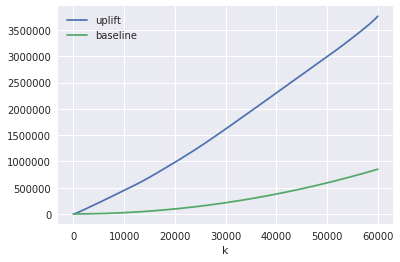

In [157]:
import matplotlib.pyplot as plt

df.plot(kind='line',x='k',y=['uplift', 'baseline'])
plt.show()